In [1]:
import os
import time
import copy
import random
from collections import defaultdict

import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
IMG_H = 256
IMG_W = 256

DATA_DIR = '../data/resampled_png/'

## Convert from .bmp to .jpg

In [16]:
def bmp_to_jpg(root_dir, save_path):
    data_path = os.path.join(root_dir)
    for class_dir in os.listdir(data_path):
        to_class_path = os.path.join(data_path, class_dir)
        os.makedirs(f'{save_path}{class_dir}/')
        for f_name in os.listdir(to_class_path):
            f_path = os.path.join(to_class_path, f_name)
            img = Image.open(f_path)
            new_img = img.resize((IMG_H, IMG_W))
            f_new_name = f_name.split('.')
            new_img.save(f'{save_path}{class_dir}/{f_new_name[0]}.png', 'png')

In [18]:
bmp_to_jpg('../data/resampled/', DATA_DIR)

## Augmentation and preparation

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
images_filepaths = []
class_names = {}
counter = 0
for class_name in os.listdir(DATA_DIR):
    if class_name not in class_names:
        class_names[class_name] = float(counter)
        counter += 1
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        images_filepaths.append(os.path.join(class_dir, f))
len(images_filepaths)

2500

In [5]:
class_names

{'Нормобласты': 0.0,
 'Сегментноядерный нейтрофил': 1.0,
 'Палочкоядерный нейтрофил': 2.0,
 'Миелоцит': 3.0,
 'Бласты': 4.0}

In [6]:
random.seed(42)
random.shuffle(images_filepaths)
train_images_filepaths = images_filepaths[:1800]
val_images_filepaths = images_filepaths[1800:-250]
test_images_filepaths = images_filepaths[-250:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

1800 450 250


In [7]:
class Cells(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image/255)
        
        class_name = image_filepath.split(sep='/')[-2]
        label = class_names[class_name]
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [8]:
# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
#     A.IAAAdditiveGaussianNoise(),
    A.RandomGamma(),
    ToTensorV2(),
])

In [9]:
train_dataset = Cells(train_images_filepaths, transform)
val_dataset = Cells(val_images_filepaths, transform)

In [10]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()   

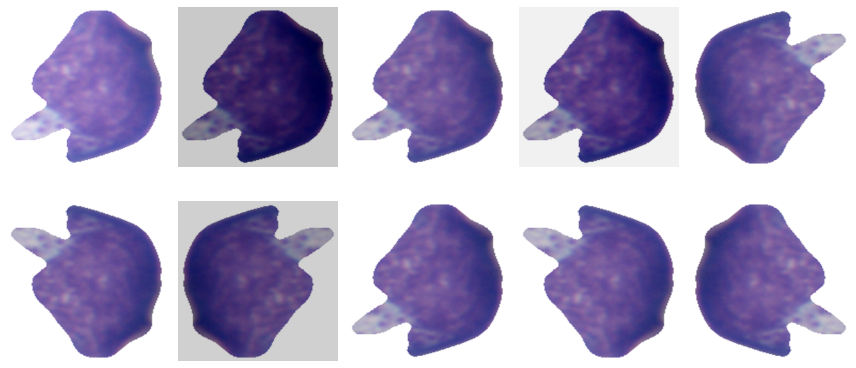

In [11]:
random.seed(42)
visualize_augmentations(train_dataset)

In [12]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [13]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True,
)

In [15]:
model = models.mobilenet_v3_large()
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
# criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [17]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [18]:
for epoch in range(1, 10):
    train(train_loader, model, criterion, optimizer, epoch)
    validate(val_loader, model, criterion, epoch)

  0%|          | 0/57 [00:00<?, ?it/s]


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward